In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from tqdm import tqdm
import seaborn as sns
import librosa
from librosa import display
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from tensorflow.keras.utils import plot_model
import warnings
warnings.filterwarnings('ignore', category=UserWarning)

import random

# Set seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)
random.seed(42)

2024-11-14 05:54:49.896655: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-14 05:54:50.456572: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


# Normalized features

In [2]:


# Define the path to your dataset
path = "/home/muzaffar/Desktop/Research/papers/mono-model-word-spoken/paper-001-final/1-20 data/ORIGINAL-SLOW-1-20"
dataset_path = path

# Initialize lists to hold features and labels
feature_list = []
label_list = []

# Define a function to normalize the mel-spectrogram
def normalize_mel_spectrogram(mel_spec):
    return (mel_spec - np.mean(mel_spec)) / np.std(mel_spec)

# Define the sample rate (fs)
fs = 16000  # Sample rate in Hz

# Define frame size and overlap based on sample rate (in seconds)
frame_size = int(0.025 * fs)  # 25 ms frame size
overlap = int(0.020 * fs)     # 20 ms overlap size

# Update the feature extraction process
for class_folder in os.listdir(dataset_path):
    class_path = os.path.join(dataset_path, class_folder)

    for file in tqdm(os.listdir(class_path)):
        if not file.endswith('.wav'):
            continue

        audio_path = os.path.join(class_path, file)
        audio, sr = librosa.load(path=audio_path, sr=None)

        # Extract the mel-spectrogram features using the frame size and overlap defined above
        mel_spec = librosa.feature.melspectrogram(y=audio, sr=sr, n_fft=frame_size, hop_length=overlap, n_mels=42)
        mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)
        normalized_mel_spec = normalize_mel_spectrogram(mel_spec_db)

        # Pad or truncate to a fixed size
        fixed_size = 32
        if normalized_mel_spec.shape[1] < fixed_size:
            # Pad with zeros
            pad_width = fixed_size - normalized_mel_spec.shape[1]
            padded_mel_spec = np.pad(normalized_mel_spec, ((0, 0), (0, pad_width)), mode='constant')
        else:
            # Truncate to fixed size
            padded_mel_spec = normalized_mel_spec[:, :fixed_size]

        feature_list.append(padded_mel_spec.T)
        label_list.append(class_folder)

# Convert to NumPy arrays
features = np.array(feature_list)
labels = np.array(label_list)

print("Feature shape:", features.shape)
print("Label shape:", labels.shape)


100%|██████████| 361/361 [00:00<00:00, 1084.35it/s]

Feature shape: (7200, 32, 42)
Label shape: (7200,)


In [3]:
features[1].shape

(32, 42)

2024-11-14 05:54:57.913621: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-11-14 05:54:57.949429: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-11-14 05:54:57.949608: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

Training on fold 1...


L355
2024-11-14 05:54:57.950927: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-11-14 05:54:57.951082: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-11-14 05:54:58.001876: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#

Epoch 1/30


2024-11-14 05:55:00.007080: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8906


180/180 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.0986 - loss: 2.9014 - val_accuracy: 0.2792 - val_loss: 2.3322
Epoch 2/30
180/180 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.2603 - loss: 2.3064 - val_accuracy: 0.4194 - val_loss: 1.8271
Epoch 3/30
180/180 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.3989 - loss: 1.8433 - val_accuracy: 0.5153 - val_loss: 1.5008
Epoch 4/30
180/180 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.4863 - loss: 1.5406 - val_accuracy: 0.5986 - val_loss: 1.2198
Epoch 5/30
180/180 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5564 - loss: 1.3323 - val_accuracy: 0.6340 - val_loss: 1.1054
Epoch 6/30
180/180 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6207 - loss: 1.1802 - val_accuracy: 0.6708 - val_loss: 1.0361
Epoch 7/30
180/180 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6597 - loss: 1.0705 - val_accuracy: 0.6854 - val_loss: 0.9754
Epoch 8/30
180/180 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6944 - loss: 0.9590 - val_accuracy: 0.7063 - val_

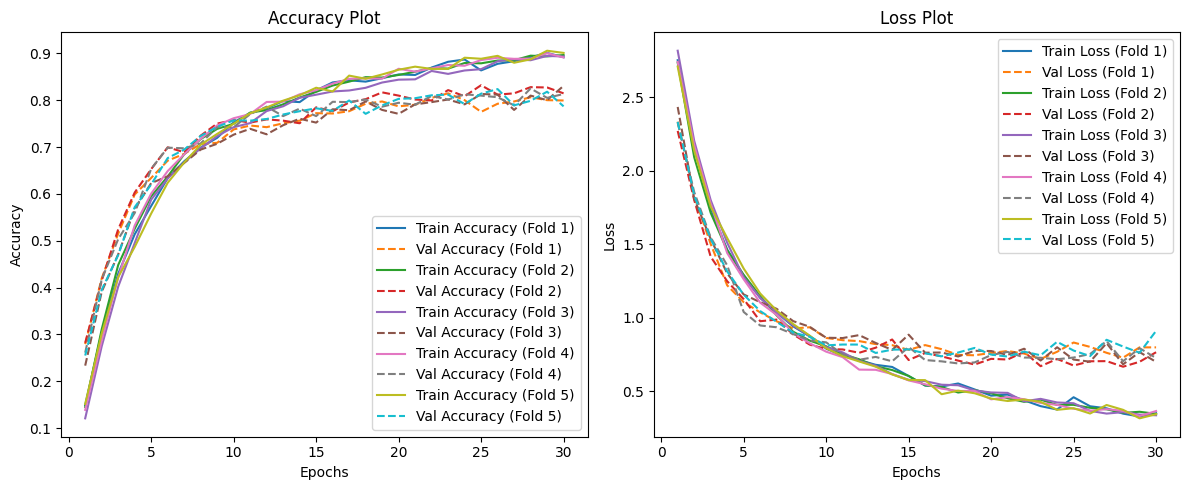

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.callbacks import EarlyStopping
from sklearn.model_selection import KFold

# Assuming 'features' and 'labels' arrays from the previous step
# One-hot encode labels
unique_labels = np.unique(labels)
label_map = {label: idx for idx, label in enumerate(unique_labels)}
encoded_labels = np.array([label_map[label] for label in labels])
categorical_labels = to_categorical(encoded_labels)

# Define cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Variables to store all true and predicted labels for confusion matrix and classification report
all_true_labels = []
all_predicted_labels = []

# Variables to store accuracy and loss for plotting each fold
train_accuracies_folds = []
val_accuracies_folds = []
train_losses_folds = []
val_losses_folds = []

# Function to create an LSTM model
def create_lstm_model(input_shape, num_classes):
    model = Sequential()
    model.add(LSTM(64, return_sequences=True, input_shape=input_shape))
    model.add(Dropout(0.3))
    model.add(LSTM(64))
    model.add(Dropout(0.3))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Perform 5-fold cross-validation
fold = 1
for train_index, val_index in kf.split(features):
    print(f"Training on fold {fold}...")
    fold += 1
    
    # Split data
    X_train, X_val = features[train_index], features[val_index]
    y_train, y_val = categorical_labels[train_index], categorical_labels[val_index]

    # Get input shape and number of classes
    input_shape = (X_train.shape[1], X_train.shape[2])
    num_classes = categorical_labels.shape[1]

    # Create and compile the model
    model = create_lstm_model(input_shape, num_classes)

    # Early stopping for better training
    #early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    # Train the model
    history = model.fit(X_train, y_train, 
              epochs=30,  # You can adjust the number of epochs
              batch_size=32, 
              validation_data=(X_val, y_val), 
              #callbacks=[early_stopping], 
              verbose=1)
    
    # Store training and validation accuracy and loss for the fold
    train_accuracies_folds.append(history.history['accuracy'])
    val_accuracies_folds.append(history.history['val_accuracy'])
    train_losses_folds.append(history.history['loss'])
    val_losses_folds.append(history.history['val_loss'])

    # Predict the labels on the validation set
    val_predictions = np.argmax(model.predict(X_val), axis=1)
    true_labels = np.argmax(y_val, axis=1)

    # Store true and predicted labels
    all_true_labels.extend(true_labels)
    all_predicted_labels.extend(val_predictions)

# Plot accuracy and loss plots
epochs = np.arange(1, len(train_accuracies_folds[0]) + 1)

plt.figure(figsize=(12, 5))

# Accuracy plot for each fold
plt.subplot(1, 2, 1)
for i, (train_acc, val_acc) in enumerate(zip(train_accuracies_folds, val_accuracies_folds)):
    plt.plot(epochs, train_acc, label=f'Train Accuracy (Fold {i+1})')
    plt.plot(epochs, val_acc, label=f'Val Accuracy (Fold {i+1})', linestyle='--')

plt.title('Accuracy Plot')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss plot for each fold
plt.subplot(1, 2, 2)
for i, (train_loss, val_loss) in enumerate(zip(train_losses_folds, val_losses_folds)):
    plt.plot(epochs, train_loss, label=f'Train Loss (Fold {i+1})')
    plt.plot(epochs, val_loss, label=f'Val Loss (Fold {i+1})', linestyle='--')

plt.title('Loss Plot')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


Overall Accuracy: 80.89%
Classification Report:
               precision    recall  f1-score   support

        Aeth     0.7774    0.7083    0.7413       360
         Akh     0.7929    0.8083    0.8006       360
       Ardah     0.7973    0.8083    0.8028       360
         Bah     0.8506    0.8222    0.8362       360
     Czhodah     0.7355    0.7028    0.7188       360
         Dah     0.6841    0.7639    0.7218       360
         Kah     0.8363    0.7944    0.8148       360
      Kunvuh     0.8000    0.8444    0.8216       360
         Nav     0.8258    0.8167    0.8212       360
      Paanch     0.7402    0.8389    0.7865       360
      Pandah     0.8169    0.8306    0.8237       360
       Sadah     0.7827    0.7806    0.7816       360
        Sath     0.8000    0.8556    0.8268       360
        Sheh     0.8316    0.8778    0.8541       360
      Shurah     0.8612    0.8444    0.8527       360
        Thre     0.8813    0.8250    0.8522       360
      Truwah     0.8592    0.830

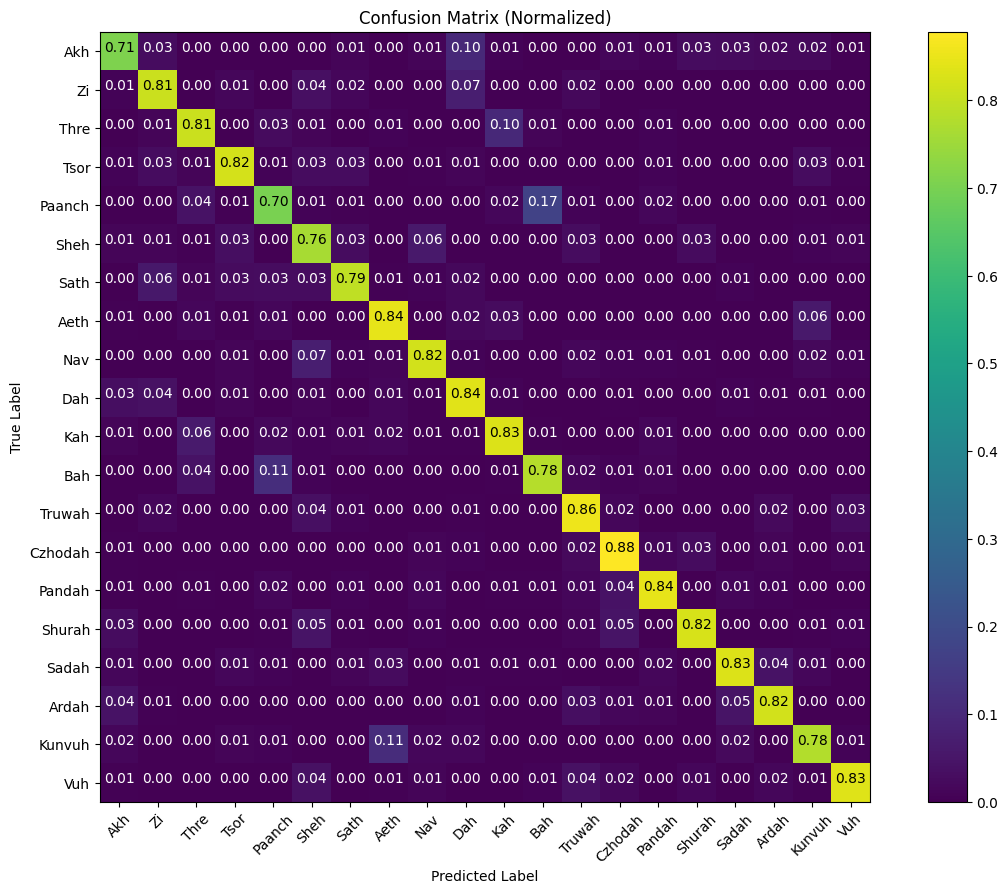

<Figure size 640x480 with 0 Axes>

In [5]:
# Calculate overall accuracy
accuracy = accuracy_score(all_true_labels, all_predicted_labels)
print(f"Overall Accuracy: {accuracy * 100:.2f}%")

# Generate classification report
class_report = classification_report(all_true_labels, all_predicted_labels, target_names=unique_labels,  digits =4)
print("Classification Report:\n", class_report)

# Generate the confusion matrix
conf_matrix = confusion_matrix(all_true_labels, all_predicted_labels)

# Normalize the confusion matrix by row (true labels)
conf_matrix_normalized = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

# Plot confusion matrix as heatmap with annotated percentages
plt.figure(figsize=(15, 10))
plt.imshow(conf_matrix_normalized, cmap='viridis', interpolation='nearest')

# Choose appropriate text color based on background color
threshold = conf_matrix_normalized.max() / 2.

for i in range(conf_matrix_normalized.shape[0]):
    for j in range(conf_matrix_normalized.shape[1]):
        color = "white" if conf_matrix_normalized[i, j] < threshold else "black"
        plt.text(j, i, format(conf_matrix_normalized[i, j], '.2f'), horizontalalignment="center", color=color)

# Custom ticks for confusion matrix
custom_ticks = ['Akh', 'Zi', 'Thre', 'Tsor', 'Paanch', "Sheh", "Sath", "Aeth", "Nav", "Dah",
                "Kah", "Bah", "Truwah", "Czhodah", "Pandah", "Shurah", "Sadah", "Ardah", "Kunvuh", "Vuh"]
plt.xticks(np.arange(20), custom_ticks, rotation=45)
plt.yticks(np.arange(20), custom_ticks)

plt.colorbar()
plt.title('Confusion Matrix (Normalized)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()




plt.tight_layout()
plt.show()


In [6]:
# Calculate the confusion matrix
conf_matrix = confusion_matrix(all_true_labels, all_predicted_labels)

# Calculate the accuracy for each class
class_accuracies = conf_matrix.diagonal() / conf_matrix.sum(axis=1)

# Display the accuracy of each class
for i, class_name in enumerate(custom_ticks):
    print(f"Accuracy for class '{class_name}': {class_accuracies[i] * 100:.2f}%")


from sklearn.metrics import precision_score, recall_score, f1_score, classification_report, confusion_matrix

# Print the overall classification report which includes precision, recall, and F1-score for each class
class_report = classification_report(all_true_labels, all_predicted_labels, target_names=custom_ticks, digits=4)
print("Classification Report:\n", class_report)

# Calculate and print the overall metrics
overall_precision = precision_score(all_true_labels, all_predicted_labels, average='weighted')
overall_recall = recall_score(all_true_labels, all_predicted_labels, average='weighted')
overall_f1 = f1_score(all_true_labels, all_predicted_labels, average='weighted')

print(f"Overall Precision: {overall_precision * 100:.2f}%")
print(f"Overall Recall: {overall_recall * 100:.2f}%")
print(f"Overall F1-Score: {overall_f1 * 100:.2f}%")

Accuracy for class 'Akh': 70.83%
Accuracy for class 'Zi': 80.83%
Accuracy for class 'Thre': 80.83%
Accuracy for class 'Tsor': 82.22%
Accuracy for class 'Paanch': 70.28%
Accuracy for class 'Sheh': 76.39%
Accuracy for class 'Sath': 79.44%
Accuracy for class 'Aeth': 84.44%
Accuracy for class 'Nav': 81.67%
Accuracy for class 'Dah': 83.89%
Accuracy for class 'Kah': 83.06%
Accuracy for class 'Bah': 78.06%
Accuracy for class 'Truwah': 85.56%
Accuracy for class 'Czhodah': 87.78%
Accuracy for class 'Pandah': 84.44%
Accuracy for class 'Shurah': 82.50%
Accuracy for class 'Sadah': 83.06%
Accuracy for class 'Ardah': 81.67%
Accuracy for class 'Kunvuh': 77.50%
Accuracy for class 'Vuh': 83.33%
Classification Report:
               precision    recall  f1-score   support

         Akh     0.7774    0.7083    0.7413       360
          Zi     0.7929    0.8083    0.8006       360
        Thre     0.7973    0.8083    0.8028       360
        Tsor     0.8506    0.8222    0.8362       360
      Paanch     0